In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim

from data_helpers import plot_photons_histograms
from model import ConditionalModel

DATA_PATH = "/data2/etude/annkon/data"
CKPT_PATH = "/data2/etude/annkon/checkpoints"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


(9957622, 6)


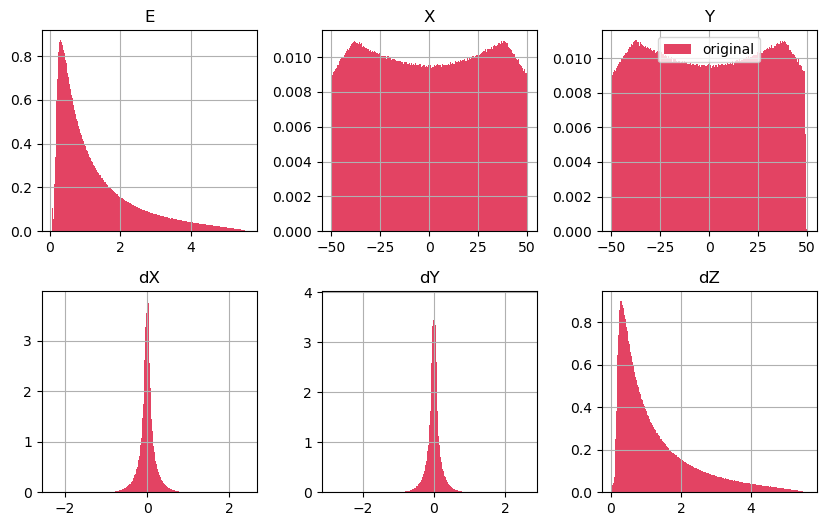

In [2]:
photons = np.load(f'{DATA_PATH}/photons_XYTE_E5.6_s0.0_a1.5.npy')
print(photons.shape)
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
plot_photons_histograms(photons, axs, figs, title='')

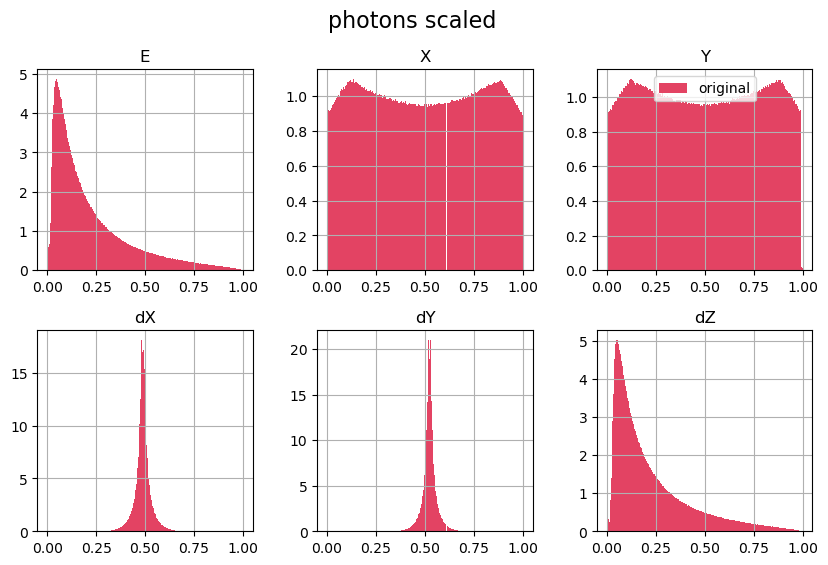

In [3]:
mmsc = MinMaxScaler()
photons_mm = mmsc.fit_transform(photons)
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
plot_photons_histograms(photons_mm, axs, figs, title='photons scaled')

In [4]:
# # # # # # # # # #   IMPLEMENTING FORWARD PROCESS   # # # # # # # # # # # # # # # # #

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    elif schedule == 'warmup10':
        betas = _warmup_beta(start, end, n_timesteps, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(start, end, n_timesteps, 0.5)
    else:
        raise NotImplementedError(schedule)
    
    return betas


def _warmup_beta(start, end, n_timestep, warmup_frac):

    betas               = end * torch.ones(n_timestep)
    warmup_time         = int(n_timestep * warmup_frac)
    betas[:warmup_time] = torch.linspace(start, end, warmup_time)

    return betas


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))  # gathers values along an axis (input, dim, index)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0).to(device)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)


n_steps = 100
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-5, end=1e-2)
betas = betas.to(device)

# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas = alphas.to(device)
alphas_prod = torch.cumprod(alphas, 0).to(device)
alphas_bar_sqrt = torch.sqrt(alphas_prod).to(device)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod).to(device)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod).to(device)

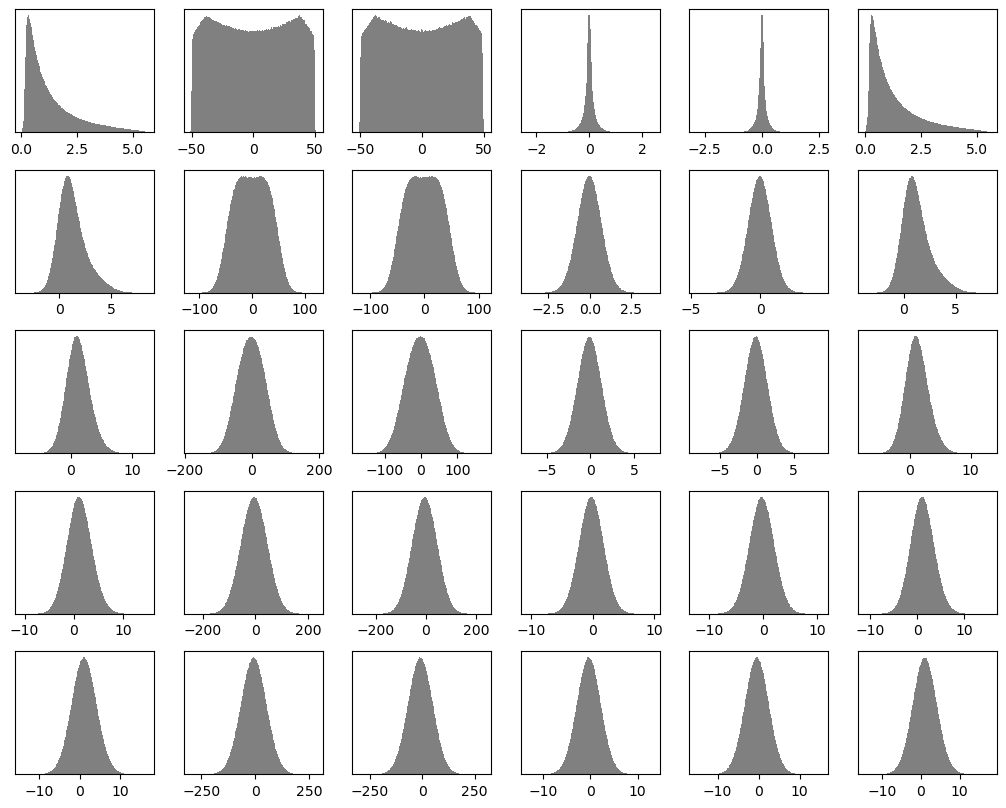

In [5]:
def plot_diffusion():
    figs, axs = plt.subplots(nrows=5, ncols=6, figsize=(10,8))
    for i in range(5):
        q_i = q_sample(dataset, torch.tensor([i * 20]).to(device))
        inv_q_i = mmsc.inverse_transform(q_i.detach().cpu().numpy())
        for j in range(6):
            axs[i][j].hist(inv_q_i[:, j], bins=300, color='grey', density=True)
            axs[i][j].set_yticks([])
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
dataset = torch.tensor(photons_mm).float().to(device)
plot_diffusion()

In [6]:
def p_sample(model, x, t):
    t = torch.tensor([t]).to(device)
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x)).to(device)
    eps_theta = model(x, t).to(device)
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta)).to(device)
    z = torch.randn_like(x).to(device)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt().to(device)
    sample = mean + sigma_t * z
    return (sample)


def p_sample_loop(model, shape):
    # noise from Gauss distribution
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x.detach().cpu()]
    # gradually denoise distribution
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x.detach().cpu())
    return x_seq


def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long().to(device)
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(device)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(device)
    e = torch.randn_like(x_0).to(device)
    # model input
    x = x_0 * a + e * am1
    x = x.to(device)
    output = model(x, t)
    return (e - output).square().mean()

In [7]:
model = ConditionalModel(n_steps)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(photons_mm).float().to(device)
n_epochs = 301


batch_size = 10000
for t in range(n_epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices].to(device)
        loss = noise_estimation_loss(model, batch_x)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (t % 100 == 0):
        print(loss)
        torch.save({
            'epoch' : t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, f"{CKPT_PATH}/DDPM_XYTE_warmup50_noema_epoch{t}.pt")

tensor(0.2555, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2193, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)
